# word2vec + XGBoost Classifier
- word2vec: opcode sequence를 임베딩
- XGBoost Classifier: 임베딩값을 분류
- accuracy: 0.992169507139567
- dataset1(DikeDataset): https://github.com/iosifache/DikeDataset
- dataset2(GnuWin Packages): http://gnuwin32.sourceforge.net/packages.html

# 필요 pacakge 설치

In [1]:
!pip install pefile
!pip install capstone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 666 kB/s 
  Created wheel for pefile: filename=pefile-2021.9.3-py3-none-any.whl size=68844 sha256=180fe18826a482b973ce188bbde9c67b427e115e0afe31437f47b1d17769d0fe
  Stored in directory: /root/.cache/pip/wheels/50/be/9b/d19a6151b9c6e303f823faedf03193d7e90dac4009a0bdafeb
Successfully built pefile
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 26.6 MB/s 


# utils.py 파일, sample 파일이 있는 폴더로 위치 변경

In [2]:
%cd /content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/휴지통/test

/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/휴지통/test


# 필요 package Import

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import time

from utils import *

# Data load
- OpcodeExtracter.ipynb 파일을 통해 pickle 형태로 1차로 데이터를 추출하고 테스트하는 것을 추천 드립니다.
- 악성코드 및 양성코드는 보안 관계상 올리지 못하였고, 저희가 생성한 Malware과 Benign Opcode dataset이 저장된 pickle 파일들은 용량 관계상 github load를 생략하였습니다.
- 본 모델과 같게 모델을 학습하는 것을 희망한다면, utils 디렉토리 내에 있는 OpcodeExtracter.ipynb 파일을 통해 데이터셋 pickle 파일을 생성하셔서 입력하시면 됩니다.
- Dataset은 DikeDataset과 임의로 크롤링한 gnu file 약 1000개를 사용하였습니다.
- DikeDataset: https://github.com/iosifache/DikeDataset

## MalwareDataset load(Dictionary 형태)

In [4]:
with open('/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/opcode database/MalwareOpcodes.p', 'rb') as file:    # james.p 파일을 바이너리 읽기 모드(rb)로 열기
    MalwareDataset = pickle.load(file)

print(list(MalwareDataset.values())[0])

['push', 'mov', 'sub', 'push', 'push', 'push', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'call', 'mov', 'cmp', 'jbe', 'mov', 'mov', 'mov', 'mov', 'mov', 'cmp', 'jmp', 'push', 'call', 'mov', 'push', 'mov', 'push', 'call', 'add', 'mov', 'adc', 'xchg', 'cmp', 'jo', 'inc', 'add', 'push', 'push', 'call', 'xor', 'pop', 'pop', 'pop', 'mov', 'pop', 'ret', 'push', 'mov', 'sub', 'push', 'push', 'push', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'cmp', 'je', 'mov', 'mov', 'mov', 'push', 'mov', 'shl', 'mov', 'pop', 'mov', 'jmp', 'mov', 'mov', 'mov', 'push', 'mov', 'sub', 'mov', 'mov', 'mov', 'mov', 'pop', 'mov', 'mov', 'add', 'mov', 'mov', 'mov', 'sub', 'mov', 'push', 'pop', 'mov', 'mov', 'add', 'mov', 'push', 'lea', 'push', 'mov', 'mov', 'lea', 'push', 'call', 'add', 'push', 'lea', 'push', 'lea', 'push', 'call', 'add', 'mov', 'mov', 'mov', 'add', 'mov', 'mov', 'add', 'mov', 'push'

## BenignDataset load

### DikeDataset(Dictionary 형태)

In [5]:
with open('/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/opcode database/BenignOpcodes.p', 'rb') as file:    # james.p 파일을 바이너리 읽기 모드(rb)로 열기
    BenignDataset = pickle.load(file)

print(list(BenignDataset.values())[0])

['ret', 'dec', 'mov', 'xor', 'dec', 'lea', 'inc', 'mov', 'dec', 'cmp', 'inc', 'mov', 'inc', 'mov', 'inc', 'inc', 'test', 'js', 'inc', 'mov', 'dec', 'test', 'je', 'dec', 'sub', 'dec', 'sub', 'dec', 'lea', 'dec', 'test', 'je', 'inc', 'test', 'je', 'mov', 'dec', 'add', 'dec', 'dec', 'dec', 'test', 'dec', 'sub', 'inc', 'mov', 'jmp', 'dec', 'test', 'je', 'mov', 'dec', 'mov', 'inc', 'mov', 'ret', 'dec', 'lea', 'dec', 'mov', 'ret', 'inc', 'push', 'dec', 'sub', 'dec', 'lea', 'dec', 'mov', 'dec', 'mov', 'test', 'je', 'call', 'dec', 'mov', 'dec', 'add', 'pop', 'ret', 'inc', 'mov', 'dec', 'mov', 'dec', 'mov', 'ret', 'inc', 'push', 'dec', 'sub', 'dec', 'mov', 'dec', 'mov', 'inc', 'mov', 'dec', 'lea', 'call', 'dec', 'mov', 'dec', 'cmp', 'mov', 'cmp', 'mov', 'jmp', 'xor', 'dec', 'add', 'pop', 'ret', 'dec', 'cmp', 'inc', 'cmp', 'mov', 'ret', 'xor', 'ret', 'dec', 'lea', 'ret', 'dec', 'mov', 'dec', 'mov', 'push', 'dec', 'sub', 'dec', 'mov', 'dec', 'mov', 'dec', 'mov', 'xor', 'mov', 'inc', 'mov', 'call'

### GnuWin Packages(List 형태)

In [6]:
with open('/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/opcode database/BenignOpcodes2.p', 'rb') as file:    # james.p 파일을 바이너리 읽기 모드(rb)로 열기
    BenignDataset2 = pickle.load(file)

print(list(BenignDataset2.values())[0])

['push', 'mov', 'sub', 'mov', 'call', 'call', 'mov', 'xor', 'pop', 'ret', 'mov', 'push', 'mov', 'sub', 'mov', 'call', 'call', 'mov', 'xor', 'pop', 'ret', 'mov', 'push', 'mov', 'sub', 'mov', 'mov', 'call', 'mov', 'pop', 'ret', 'lea', 'lea', 'push', 'mov', 'sub', 'mov', 'mov', 'call', 'mov', 'pop', 'ret', 'lea', 'lea', 'push', 'mov', 'push', 'sub', 'mov', 'call', 'sub', 'call', 'mov', 'mov', 'lea', 'mov', 'mov', 'mov', 'lea', 'mov', 'mov', 'call', 'mov', 'test', 'je', 'mov', 'mov', 'test', 'je', 'mov', 'mov', 'mov', 'call', 'mov', 'cmp', 'je', 'mov', 'mov', 'mov', 'mov', 'call', 'mov', 'cmp', 'je', 'mov', 'mov', 'mov', 'mov', 'call', 'call', 'mov', 'mov', 'call', 'call', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'call', 'mov', 'call', 'mov', 'call', 'lea', 'push', 'mov', 'sub', 'mov', 'mov', 'xor', 'mov', 'xor', 'mov', 'mov', 'cmp', 'ja', 'cmp', 'jae', 'cmp', 'je', 'mov', 'mov', 'mov', 'mov', 'pop', 'ret', 'mov', 'mov', 'call', 'cmp', 'je', 'test', 'je', 'mov', 'lea', 'lea', 'call', 'mov

## opcode 리스트 로드
- file 폴더에 있는 opcodesList.txt 파일을 filePath로 설정하시면 됩니다.

In [40]:
filePath = '/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/opcode database/opcodesList.txt'
with open(filePath, 'rb') as lf:
    opcodes = pickle.load(lf)
    print(opcodes)

['aaa', 'aad', 'aam', 'aas', 'adc', 'add', 'and', 'call', 'cbw', 'clc', 'cld', 'cli', 'cmc', 'cmp', 'cmpsb', 'cmpsw', 'cwd', 'daa', 'das', 'dec', 'div', 'esc', 'hlt', 'idiv', 'imul', 'in', 'inc', 'int', 'into', 'iret', 'jcc', 'ja', 'jae', 'jb', 'jbe', 'jc', 'je', 'jg', 'jge', 'jl', 'jle', 'jnle', 'jno', 'jnp', 'jns', 'jnz', 'jo', 'jp', 'jpe', 'jpo', 'js', 'jz', 'jcxz', 'jmp', 'lahf', 'lds', 'lea', 'les', 'lock', 'lodsb', 'lodsw', 'loop', 'loope', 'loopne', 'loopnz', 'loopz', 'loopx', 'mov', 'movsb', 'movsw', 'mul', 'neg', 'nop', 'not', 'or', 'out', 'pop', 'popf', 'push', 'pushf', 'rcl', 'rcr', 'repxx', 'rep', 'repe', 'repne', 'repnz', 'repz', 'ret', 'retn', 'retf', 'rol', 'ror', 'sahf', 'sal', 'sar', 'sbb', 'scasb', 'scasw', 'shl', 'shr', 'stc', 'std', 'sti', 'stosb', 'stosw', 'sub', 'test', 'wait', 'xchg', 'xlat', 'xor']


# 전체를 통합한 DataFrame 생성

## Malware DataFrame

In [12]:
nameList = list(MalwareDataset.keys())
opcodeList = list(MalwareDataset.values())
LenList = [len(op) for op in opcodeList]

MalwareDict = {'Name' : nameList,
           'opcodeSequence' : opcodeList,
           'Len' : LenList,
           'class' : [1 for i in range(len(opcodeList))]}

MalwareDf = pd.DataFrame.from_dict(MalwareDict)

In [13]:
MalwareDf.head()

,Name,opcodeSequence,Len,class
0,0004b6ce277aa1a259359ee0400bf7cb3f2aafdeeae291...,"[push, mov, sub, push, push, push, mov, mov, m...",4129,1
1,00145e98e0394c0ad3f0e1fc801676f426ed657d064076...,"[push, mov, sub, push, push, push, mov, mov, m...",7285,1
2,00255bab3a31b108a9de13b0944a50b5fa866dc53c139c...,"[add, xchg, add, add, add, add, xchg, xchg, ad...",5209,1
3,002d72a4eb8f8e2aaea0efd51128afaf0d291b9483dc68...,"[push, mov, sub, push, push, mov, mov, mov, mo...",9730,1
4,004843d2d85eb96ccd4e5e3dc7f54ed114753bc589af55...,"[push, mov, sub, sub, mov, push, add, push, pu...",50979,1


## Benign DataFrame1

In [14]:
nameList = list(BenignDataset.keys())
opcodeList = list(BenignDataset.values())
LenList = [len(op) for op in opcodeList]


BenignDict = {'Name' : nameList,
           'opcodeSequence' : opcodeList,
           'Len' : LenList,
           'class' : [0 for i in range(len(opcodeList))]}

BenignDf = pd.DataFrame.from_dict(BenignDict)

In [15]:
BenignDf.head()

,Name,opcodeSequence,Len,class
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,"[ret, dec, mov, xor, dec, lea, inc, mov, dec, ...",99752,0
1,003851675800dc05cdac1baa84cab8f68534b244906d97...,"[ret, nop, nop, dec, sub, dec, mov, xor, mov, ...",4074,0
2,00eea85752664955047caad7d6280bc7bf1ab91c61eb9a...,"[ret, nop, nop, dec, sub, dec, mov, xor, mov, ...",7549,0
3,0111bddac92a792c7b2ee3ab77642c33df0e01afe737b0...,"[push, mov, sub, mov, test, je, and, mov, or, ...",11917,0
4,016584e586de67b725ac1e3974fcca320bf81c8c489ebb...,"[mov, shl, mov, push, push, xor, mov, mov, cmp...",15636,0


## Benign DataFrame2

In [16]:
nameList = list(BenignDataset2.keys())
opcodeList = list(BenignDataset2.values())
LenList = [len(op) for op in opcodeList]

BenignDict2 = {'Name' : nameList,
           'opcodeSequence' : opcodeList,
           'Len' : LenList,
           'class' : [0 for i in range(len(opcodeList))]}

BenignDf2 = pd.DataFrame.from_dict(BenignDict2)

In [17]:
BenignDf2.head()

,Name,opcodeSequence,Len,class
0,411toppm.exe,"[push, mov, sub, mov, call, call, mov, xor, po...",1480,0
1,a2ps-4.14-1-setup.exe,"[or, jae, jb, add, add, add, add, add, add, ad...",13499,0
2,a2ps-4.14-1-src-setup.exe,"[or, jae, jb, add, add, add, add, add, add, ad...",13499,0
3,a2ps.exe,"[push, mov, sub, mov, mov, xor, mov, mov, xor,...",72897,0
4,abs.exe,"[push, mov, sub, mov, call, call, mov, xor, po...",699,0


# word2vec model 학습을 위한 sequence list 생성

In [18]:
opcodeSequenceList = MalwareDf['opcodeSequence'].to_list()
opcodeSequenceList += BenignDf['opcodeSequence'].to_list()
opcodeSequenceList += BenignDf2['opcodeSequence'].to_list()

# word2vec 모델 학습 및 저장

 ## word2vec Model Train

In [19]:
word2vecModel = Word2Vec(sentences=opcodeSequenceList, size=1000, window=5, min_count=5, workers=4, sg=0)

## Trained word2vec model save and load

In [21]:
modelPath = '/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/machineLearningModel/03word2vec 기반 MachineLearning Model/w2v'
word2vecModel.wv.save_word2vec_format(modelPath)
word2vecModel = KeyedVectors.load_word2vec_format(modelPath)

## word2vec model test

In [22]:
model_result = word2vecModel.most_similar("add")
print(model_result)

[('adc', 0.29818618297576904), ('lock', 0.23788923025131226), ('rol', 0.22547423839569092), ('or', 0.21117888391017914), ('jo', 0.2012193500995636), ('aam', 0.19678421318531036), ('imul', 0.15650838613510132), ('lds', 0.14355865120887756), ('inc', 0.14117887616157532), ('sbb', 0.13891220092773438)]


# opcode Sequence Embedding

## word2vec 임베딩 값을 위한 함수
- word2vec 임베딩 값의 평균을 임베딩 값으로 사용

In [23]:
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(word2vecModel.wv[i])
        except KeyError as e:
            pass
    try:
        return np.array(np.mean(vector, axis=0), dtype = np.float64)
    except IndexError as e:
        pass

## Embedding 값 생성

In [24]:
# 토큰이 없는 질문 data 삭제
for i in range(len(MalwareDf['Len'])):
    if MalwareDf['Len'][i] == 0:
        MalwareDf.drop([i], inplace=True)

# 중간 부분들이 행이 작제되면 인덱스 값에도 빈 공간이 생겨서 다시 채워주어야 함
index_=range(len(MalwareDf['Len']))
MalwareDf['index']=index_
MalwareDf.set_index('index', append=True)
MalwareDf.set_index('index', inplace=True)

# 토큰이 없는 질문 data 삭제
for i in range(len(BenignDf['Len'])):
    if BenignDf['Len'][i] == 0:
        BenignDf.drop([i], inplace=True)

# 중간 부분들이 행이 작제되면 인덱스 값에도 빈 공간이 생겨서 다시 채워주어야 함
index_=range(len(BenignDf['Len']))
BenignDf['index']=index_
BenignDf.set_index('index', append=True)
BenignDf.set_index('index', inplace=True)

# 토큰이 없는 질문 data 삭제
for i in range(len(BenignDf2['Len'])):
    if BenignDf2['Len'][i] == 0:
        BenignDf2.drop([i], inplace=True)

# 중간 부분들이 행이 작제되면 인덱스 값에도 빈 공간이 생겨서 다시 채워주어야 함
index_=range(len(BenignDf2['Len']))
BenignDf2['index']=index_
BenignDf2.set_index('index', append=True)
BenignDf2.set_index('index', inplace=True)

MalwareDf['wv'] = MalwareDf['opcodeSequence'].map(get_sentence_mean_vector)
BenignDf['wv'] = BenignDf['opcodeSequence'].map(get_sentence_mean_vector)
BenignDf2['wv'] = BenignDf2['opcodeSequence'].map(get_sentence_mean_vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


- name: 파일의 이름
- opcodeSequence: 하나의 파일에 있는 opcode Sequence List
- len: PEFILE 내 전체 opcode들의 개수
- class: 라벨, (1: malware, 0: Benign)
- wv: word2vec모델을 바탕으로 sequence에 대한 임베딩 값

In [25]:
MalwareDf.head()

,Name,opcodeSequence,Len,class,wv
index,,,,,
0,0004b6ce277aa1a259359ee0400bf7cb3f2aafdeeae291...,"[push, mov, sub, push, push, push, mov, mov, m...",4129,1,"[-0.24745409190654755, -0.3548027575016022, -0..."
1,00145e98e0394c0ad3f0e1fc801676f426ed657d064076...,"[push, mov, sub, push, push, push, mov, mov, m...",7285,1,"[-0.3735170364379883, -0.2357058823108673, -0...."
2,00255bab3a31b108a9de13b0944a50b5fa866dc53c139c...,"[add, xchg, add, add, add, add, xchg, xchg, ad...",5209,1,"[-0.4894099533557892, -0.03828774392604828, -0..."
3,002d72a4eb8f8e2aaea0efd51128afaf0d291b9483dc68...,"[push, mov, sub, push, push, mov, mov, mov, mo...",9730,1,"[-0.2185482382774353, -0.3712385892868042, -0...."
4,004843d2d85eb96ccd4e5e3dc7f54ed114753bc589af55...,"[push, mov, sub, sub, mov, push, add, push, pu...",50979,1,"[-0.029466452077031136, -0.19142138957977295, ..."


In [26]:
BenignDf.head()

,Name,opcodeSequence,Len,class,wv
index,,,,,
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,"[ret, dec, mov, xor, dec, lea, inc, mov, dec, ...",99752,0,"[0.09447483718395233, -0.7070435285568237, -0...."
1,003851675800dc05cdac1baa84cab8f68534b244906d97...,"[ret, nop, nop, dec, sub, dec, mov, xor, mov, ...",4074,0,"[0.12846821546554565, -0.8920444250106812, -0...."
2,00eea85752664955047caad7d6280bc7bf1ab91c61eb9a...,"[ret, nop, nop, dec, sub, dec, mov, xor, mov, ...",7549,0,"[0.07498890906572342, -0.8067811727523804, -0...."
3,0111bddac92a792c7b2ee3ab77642c33df0e01afe737b0...,"[push, mov, sub, mov, test, je, and, mov, or, ...",11917,0,"[-0.007000999059528112, -1.070807933807373, -0..."
4,016584e586de67b725ac1e3974fcca320bf81c8c489ebb...,"[mov, shl, mov, push, push, xor, mov, mov, cmp...",15636,0,"[-0.21023312211036682, -0.43138206005096436, -..."


In [27]:
BenignDf2.head()

,Name,opcodeSequence,Len,class,wv
index,,,,,
0,411toppm.exe,"[push, mov, sub, mov, call, call, mov, xor, po...",1480,0,"[-0.06822000443935394, -0.8398693799972534, -0..."
1,a2ps-4.14-1-setup.exe,"[or, jae, jb, add, add, add, add, add, add, ad...",13499,0,"[-0.2705000936985016, -0.4103069007396698, -0...."
2,a2ps-4.14-1-src-setup.exe,"[or, jae, jb, add, add, add, add, add, add, ad...",13499,0,"[-0.2705000936985016, -0.4103069007396698, -0...."
3,a2ps.exe,"[push, mov, sub, mov, mov, xor, mov, mov, xor,...",72897,0,"[-0.2128082513809204, -0.47195562720298767, -0..."
4,abs.exe,"[push, mov, sub, mov, call, call, mov, xor, po...",699,0,"[-0.1961470991373062, -0.7410380244255066, -0...."


# 독립변수와 종속변수 나누기

In [28]:
Y = MalwareDf['class'].to_list()
Y += BenignDf['class'].to_list()
Y += BenignDf2['class'].to_list()

Y = np.array(Y)

Y.shape

(10852,)

In [29]:
X = MalwareDf['wv'].to_list()
X += BenignDf['wv'].to_list()
X += BenignDf2['wv'].to_list()

X = np.array(X)

X.shape

(10852, 1000)

In [30]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8681, 1000)
(2171, 1000)
(8681,)
(2171,)


In [31]:
start = time.time() 

clf = XGBClassifier(booster = 'gbtree', importance_type = 'gain')
clf.fit(x_train,y_train)

end = time.time()
process = round(end-start,2)
print("XGBoost Classifier has fitted, this process took {} seconds".format(process))

XGBoost Classifier has fitted, this process took 44.7 seconds


In [45]:
# predict2 = svm_classifier.predict(x_test)
predict2 = clf.predict(x_test)
print(f'accuracy: {clf.score(x_test,y_test)}')

accuracy: 0.992169507139567


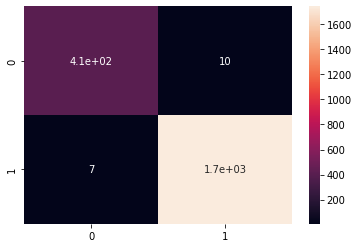

In [33]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predict2), columns=[0, 1], index=[0, 1])
sns.heatmap(cm, annot=True)

# 모델 저장

In [34]:
# 파일명
filename = 'XGB_Word2vecClassifier.model'

# 모델 저장
pickle.dump(clf, open(filename, 'wb'))

# 모델 불러오기
clf = pickle.load(open(filename, 'rb'))

# Sample file Test
- Test를 위해 utils 폴더 내부의 utils.py 파일을 활용한다.

## MalwareDetectionFunction을 통한 Malware 탐지
- 양성 샘플 파일이 양성으로 결과가 나오는지 확인
- return 1: 악성코드, return 0: 양성코드

In [48]:
# 머신러닝 모델(XGBClassifier)을 바탕으로 해당 파일이 악성코드인지를 알려주는 함수
# return 1: 악성코드, return 0: 양성코드
def MalwareDetectionFunction(model, fileName):
    try:
        #parse exe file
        exe = pefile.PE(fileName)
        #call the function we created earlier
        sampleOpcodeList = ExtractPefileOpcodes(opcodes, exe)
    except:
        print('Error File')
    
    inputData = get_sentence_mean_vector(sampleOpcodeList)
    inputData = [inputData]

    return clf.predict(inputData)[0]

- 결과가 0으로 양성파일을 탐지한 것을 확인할 수 있다.

In [49]:
fileName = '3f3fe9ecad7f30fc80cdfb678d7ca27a30d0575a73818746e98be9170d3be348.exe'

MalwareDetectionFunction(clf, fileName)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


0